## Install dependencies

In [ ]:
!pip install -U pythainlp openai-whisper transformers fairseq sacremoses matplotlib librosa

## Import dependencies

In [1]:
import torch
import whisper
from pythainlp.translate import Translate

from transformers import VitsTokenizer, VitsModel, set_seed

from IPython.display import Audio

import matplotlib.pyplot as plt
import librosa

## Load Model

In [2]:
model = whisper.load_model("medium")

## Load audio file

In [3]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("./jp-01-money.mp3")
audio = whisper.pad_or_trim(audio)

In [4]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

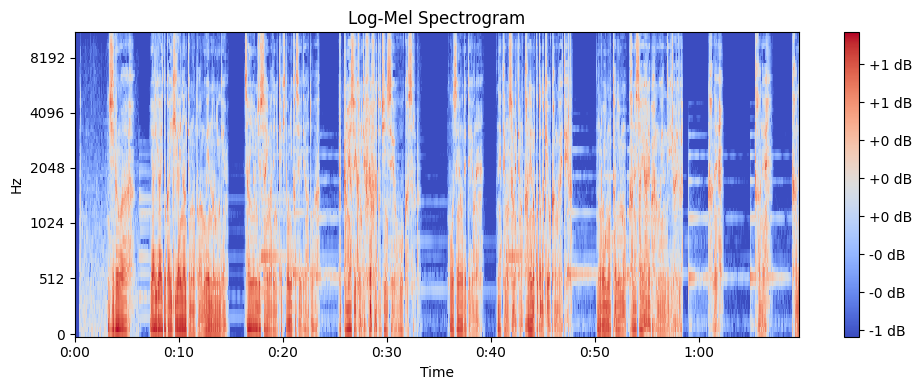

In [5]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel.cpu().numpy(), x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Detect language

In [6]:
# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

Detected language: ja


## Transcript and Translate

In [7]:
# decode the audio and print
original_options = whisper.DecodingOptions()
translate_options = whisper.DecodingOptions(task="translate")

original_result = whisper.decode(model, mel, original_options)
translate_result = whisper.decode(model, mel, translate_options)

print("Original: " + original_result.text)
print("Translate: " + translate_result.text)

Original: 自分はやりがいとか生きがいなんてものとは無縁の人間三四十歳までに適当に稼いであとは物価の安い国でふらふらと人生を謳歌する光線を出て4年寝ても覚めても金のことだけを考えている呪いも他人も金さえあれば無縁でいられる
Translate: I am a person who is willing to do anything for the sake of it. I earn money until I'm 30 or 40 years old, and then I spend my life in a country with cheap goods. After leaving the mine, I think only about money. Curse and others can be free as long as they have money.


## Translate to Thai

In [8]:
en2th = Translate('en', 'th')
th_text = en2th.translate(translate_result.text)

print("Translated Thai: " + th_text)

2024-08-06 00:13:09 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2024-08-06 00:13:09 | INFO | fairseq.file_utils | loading archive file /home/titor/pythainlp-data/scb_1m_en-th_moses_1.0/SCB_1M-MT_OPUS+TBASE_en-th_moses-spm_130000-16000_v1.0/models
2024-08-06 00:13:09 | INFO | fairseq.file_utils | loading archive file /home/titor/pythainlp-data/scb_1m_en-th_moses_1.0/SCB_1M-MT_OPUS+TBASE_en-th_moses-spm_130000-16000_v1.0/vocab
2024-08-06 00:13:12 | INFO | fairseq.tasks.translation | [en] dictionary: 130000 types
2024-08-06 00:13:12 | INFO | fairseq.tasks.translation | [th] dictionary: 15984 types
2024-08-06 00:13:13 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': './checkpoints/1m-scb+mt-opus_27.5.2020/en-th/moses-spm/130000-16000/log', 'wandb_project': None, '

Translated Thai: ฉันเป็นคนที่ยินดีที่จะทําอะไรเพื่อประโยชน์ของมัน ฉันได้รับเงินจนฉันอายุ 30 หรือ 40 ปีและจากนั้นฉันใช้ชีวิตของฉันในประเทศที่มีสินค้าราคาถูก หลังจากออกจากเหมืองฉันคิดเพียงเกี่ยวกับเงิน คําสาปและคนอื่น ๆ สามารถเป็นอิสระตราบใดที่พวกเขามีเงิน


## Import VITS model

In [9]:
vits_tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-tha")
vits_model = VitsModel.from_pretrained("facebook/mms-tts-tha")

Some weights of the model checkpoint at facebook/mms-tts-tha were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.1.wei

In [10]:
# UROMAN tokenizer check
print(vits_tokenizer.is_uroman)

False


## Generate sound

In [11]:
inputs = vits_tokenizer(text=th_text, return_tensors="pt")

set_seed(21)  # make deterministic

with torch.no_grad():
   outputs = vits_model(inputs["input_ids"])

waveform = outputs.waveform[0]

## Preview

In [12]:
Audio(waveform, rate=vits_model.config.sampling_rate)